In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import hypernetx as hnx
import math
from itertools import product
from itertools import combinations
from itertools import groupby
from collections import defaultdict
from collections import Counter
import warnings
import time
import stats
from scipy.stats import zscore
from scipy.stats import qmc
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../../source/")
sys.path.insert(0, source_path)
print(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

# hyperlocal imports
import core_utils
import nb_utils as nb
import homocore as homoc

/home/machoi/higher-order-single-cell/source
/home/machoi/higher-order-single-cell/source


In [2]:
def generate_core_periphery_hypergraph(num_core_nodes, num_periphery_nodes,
                                      edge_probability_core, edge_probability_periphery,
                                      avg_edge_size, core_periphery_probability):
    """
    This function generates a random hypergraph with a core-periphery structure and creates its binary incidence matrix.

    Args:
      num_core_nodes: Number of nodes in the core.
      num_periphery_nodes: Number of nodes in the periphery.
      edge_probability_core: Probability of an edge forming between core nodes.
      edge_probability_periphery: Probability of an edge forming between periphery nodes.
      avg_edge_size: Average number of nodes per edge.
      core_periphery_probability: Probability of an edge forming between a core node and a periphery node.

    Returns:
      A tuple containing four elements:
          * core_nodes: List of core nodes.
          * periphery_nodes: List of periphery nodes.
          * edges: List of edges.
          * incidence_matrix: Binary incidence matrix as a NumPy array.
    """
    import numpy as np

    # Define core and periphery nodes
    core_nodes = list(range(num_core_nodes))
    periphery_nodes = list(range(num_core_nodes, num_core_nodes + num_periphery_nodes))

    # Get total number of nodes
    total_nodes = len(core_nodes) + len(periphery_nodes)

    # Generate edges
    edges = []
    for _ in range(int(len(core_nodes) * edge_probability_core)):
        # Sample core nodes for an edge
        edge = random.sample(core_nodes, k=int(avg_edge_size))
        edges.append(edge)

    for _ in range(int(len(periphery_nodes) * edge_probability_periphery)):
        # Sample periphery nodes for an edge
        edge = random.sample(periphery_nodes, k=int(avg_edge_size))
        edges.append(edge)

    # Add edges between core and periphery nodes
    for _ in range(int(num_core_nodes * num_periphery_nodes * core_periphery_probability)):
        # Sample a core node and a periphery node
        core_node = random.choice(core_nodes)
        periphery_node = random.choice(periphery_nodes)
        # Create an edge with the core and periphery node
        edge = [core_node, periphery_node]
        # Optionally, you can sample additional nodes for the edge
        if avg_edge_size > 2:
            additional_nodes = random.sample(core_nodes + periphery_nodes, k=int(avg_edge_size) - 2)
            edge.extend(additional_nodes)
            
        edges.append(edge)

    # Create empty matrix
    incidence_matrix = np.zeros((total_nodes, len(edges)), dtype=int)

    # Fill the matrix with 1s for corresponding nodes in each edge
    for i, edge in enumerate(edges):
        for node in edge:
            incidence_matrix[node, i] = 1

    return core_nodes, periphery_nodes, edges, incidence_matrix

In [8]:
reload(homoc)

/home/machoi/higher-order-single-cell/source


<module 'homocore' from '/home/machoi/higher-order-single-cell/notebooks/core/homocore.py'>

(0, 1, 2)
(0, 2, 3)
(0, 2, 8)
(0, 4, 10)
(2, 10, 11)
(0, 1, 6)
(1, 5, 11)
(4, 10, 12)
This is how many nodes are in the core 3


NameError: name 'core_nodes' is not defined

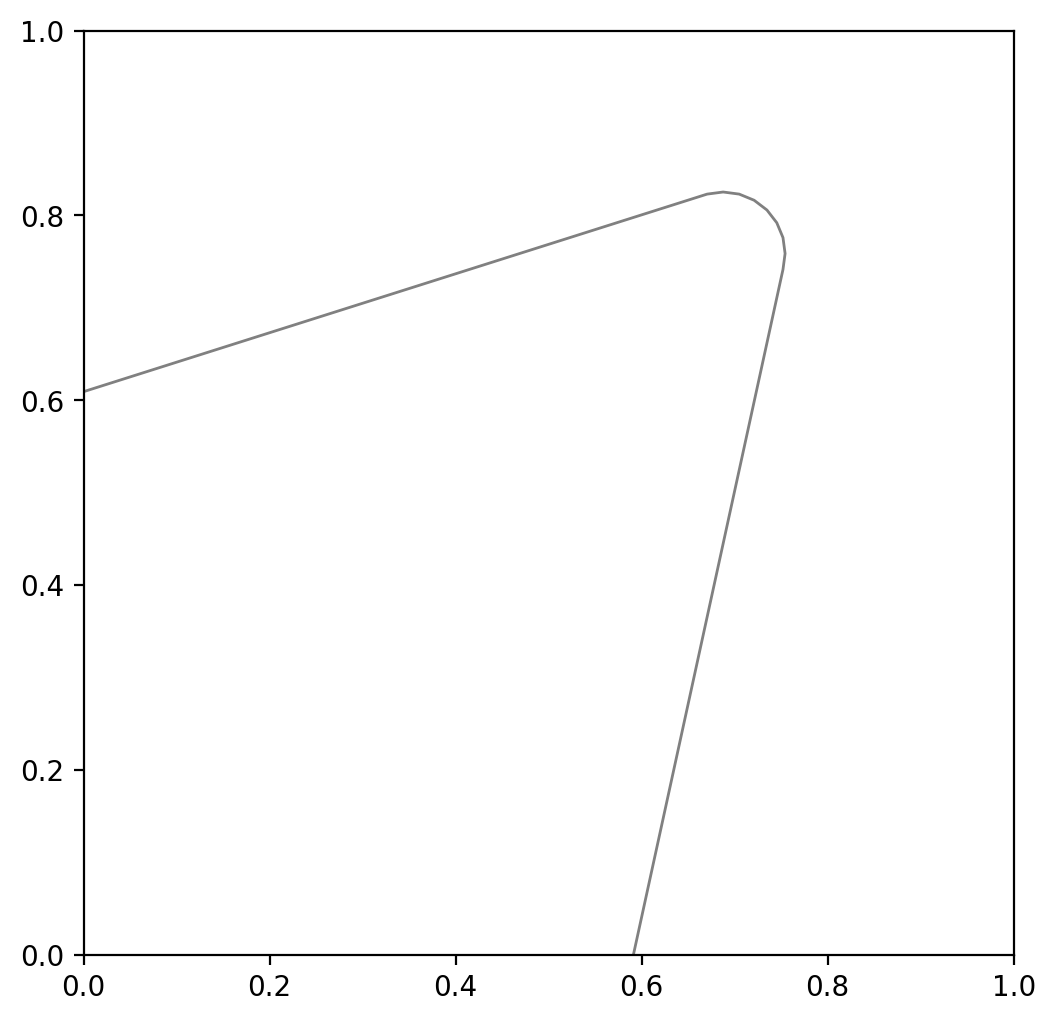

In [7]:
element = [3, 10, 0.9, 0.1, 0.2]
datacolumns = ['true_positive', 'false_positive', 'false_negative', 'num_core_nodes', 'num_periphery_nodes', 'edge_probability_core', 'edge_probability_periphery', 'avg_edge_size', 'core_periphery_probability']
experiment_df_percentage = pd.DataFrame(columns=datacolumns)
experiment_df = pd.DataFrame(columns=datacolumns)
num_core_nodes = int(element[0])
num_periphery_nodes = int(element[1])
edge_probability_core = element[2]
edge_probability_periphery = element[3] 
avg_edge_size = 3
core_periphery_probability = element[4]
core_nodes_graph, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(num_core_nodes, num_periphery_nodes, edge_probability_core, edge_probability_periphery, avg_edge_size, core_periphery_probability)
H = pd.DataFrame(incidence_matrix)
df_centrality = homoc.get_core(H, [])
G = homoc.incidence_matrix_to_hyperedges(incidence_matrix)
centrality_dict = df_centrality['node_centrality'].to_dict()
G2 = homoc.edges_by_centrality(G, centrality_dict)
core_nodes_homo, hx_homo = homoc.betterSolve(G2)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (6, 6)
hnx.drawing.draw(hx_homo, 
                     with_node_counts=False, 
                     with_edge_counts=False,
                     with_edge_labels=False, 
                     with_node_labels=False,
                     nodes_kwargs={'color': homoc.node_color, 'edgecolor': 'k'},
                     edges_kwargs={'edgecolors': 'grey'},
                     layout_kwargs={'seed': 39})

true_pos = 0
false_pos = 0
for nodes in core_nodes_homo:
    if nodes < num_core_nodes:
        true_pos += 1
    else:
        false_pos += 1
    true_neg = num_core_nodes-true_pos
                # Create a DataFrame with the new row

                # Create a DataFrame with the new row
new_row = pd.DataFrame([[true_pos, false_pos, true_neg, num_core_nodes, num_periphery_nodes, edge_probability_core, edge_probability_periphery, avg_edge_size, core_periphery_probability]], columns=datacolumns)

                # Concatenate the original DataFrame with the new row
experiment_df = pd.concat([experiment_df, new_row], ignore_index=True)

nodes = homoc.get_core(H, [])
core_nodes_percentage = sorted(nodes[nodes['core']]['local_bin'].values)
nodes = nodes.sort_values(by='zscores', ascending=False)
nodes['bin_number'] = nodes['local_bin'].astype(float)
real_core_nodes = set(core_nodes_percentage)
true_pos = 0
false_pos = 0
for nodes in real_core_nodes:
    if nodes < num_core_nodes:
        true_pos += 1
    else:
        false_pos += 1
    true_neg = num_core_nodes-true_pos
    new_row_per = pd.DataFrame([[true_pos, false_pos, true_neg, num_core_nodes, num_periphery_nodes, edge_probability_core, edge_probability_periphery, avg_edge_size, core_periphery_probability]], columns=datacolumns)

                # Concatenate the original DataFrame with the new row
experiment_df_percentage = pd.concat([experiment_df_percentage, new_row_per], ignore_index=True)
                

In [ ]:
experiment_df


In [ ]:
experiment_df_percentage


In [ ]:
break

In [9]:
'''

num_core_nodes = 25
num_periphery_nodes = 75

edge_probability_core = 0.95
edge_probability_periphery = 0.2
avg_edge_size = 4
core_periphery_probability = 0.1
'''

datacolumns = ['true_positive', 'false_positive', 'false_negative', 'num_core_nodes', 'num_periphery_nodes', 'edge_probability_core', 'edge_probability_periphery', 'avg_edge_size', 'core_periphery_probability']
experiment_df_percentage = pd.DataFrame(columns=datacolumns)
experiment_df = pd.DataFrame(columns=datacolumns)
t = time.time()

sampler = qmc.LatinHypercube(d=5)

sample = sampler.random(n=50)

l_bounds = [10, 50, 0.85, 0.15, 0.01]

u_bounds = [20, 100, 0.95, 0.25, 0.15]

sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

for avg_edge_size in range(3,6):
    for element in sample_scaled:
        num_core_nodes = int(element[0])
        num_periphery_nodes = int(element[1])
        edge_probability_core = element[2]
        edge_probability_periphery = element[3] 
        core_periphery_probability = element[4]
        core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(num_core_nodes, num_periphery_nodes, edge_probability_core, edge_probability_periphery, avg_edge_size, core_periphery_probability)
        H = pd.DataFrame(incidence_matrix)
        df_centrality = homoc.get_core(H, [])
        G = homoc.incidence_matrix_to_hyperedges(incidence_matrix)
        centrality_dict = df_centrality['node_centrality'].to_dict()
        G2 = homoc.edges_by_centrality(G, centrality_dict)
        core_nodes_homo = homoc.betterSolve(G2)
        print(core_nodes_homo)
        true_pos = 0
        false_pos = 0
        for nodes2 in core_nodes_homo:
            if nodes2 < num_core_nodes:
                true_pos += 1
            else:
                false_pos += 1
        true_neg = num_core_nodes-true_pos
                # Create a DataFrame with the new row

                # Create a DataFrame with the new row
        new_row = pd.DataFrame([[true_pos, false_pos, true_neg, num_core_nodes, num_periphery_nodes, edge_probability_core, edge_probability_periphery, avg_edge_size, core_periphery_probability]], columns=datacolumns)

                # Concatenate the original DataFrame with the new row
        experiment_df = pd.concat([experiment_df, new_row], ignore_index=True)

        nodes = homoc.get_core(H, [])
        core_nodes = sorted(nodes[nodes['core']]['local_bin'].values)
        nodes = nodes.sort_values(by='zscores', ascending=False)
        nodes['bin_number'] = nodes['local_bin'].astype(float)
        real_core_nodes = set(core_nodes)
        true_pos = 0
        false_pos = 0
        for nodes2 in real_core_nodes:
            if nodes2 < num_core_nodes:
                true_pos += 1
            else:
                false_pos += 1
        true_neg = num_core_nodes-true_pos
        new_row_per = pd.DataFrame([[true_pos, false_pos, true_neg, num_core_nodes, num_periphery_nodes, edge_probability_core, edge_probability_periphery, avg_edge_size, core_periphery_probability]], columns=datacolumns)

                # Concatenate the original DataFrame with the new row
        experiment_df_percentage = pd.concat([experiment_df_percentage, new_row_per], ignore_index=True)
                
elapsed = time.time() - t
print(f'Core Found: {elapsed} seconds')

experiment_df
experiment_df_percentage


This is how many nodes are in the core 22
{0, 1, 3, 4, 5, 6, 7, 13, 20, 22, 27, 35, 36, 49, 53, 72, 74, 80, 82, 96, 99, 101}
This is how many nodes are in the core 5
{0, 1, 2, 3, 8}
This is how many nodes are in the core 9
{0, 33, 2, 35, 3, 4, 39, 46, 50}


/tmp/ipykernel_3628313/4199353016.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_df = pd.concat([experiment_df, new_row], ignore_index=True)
/tmp/ipykernel_3628313/4199353016.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_df_percentage = pd.concat([experiment_df_percentage, new_row_per], ignore_index=True)


This is how many nodes are in the core 8
{0, 33, 2, 3, 4, 8, 12, 14}
This is how many nodes are in the core 15
{0, 33, 2, 3, 4, 101, 35, 8, 10, 44, 18, 22, 23, 93, 31}
This is how many nodes are in the core 13
{32, 1, 2, 33, 34, 5, 38, 8, 17, 50, 52, 24, 28}
This is how many nodes are in the core 16
{0, 1, 65, 3, 4, 5, 2, 67, 8, 37, 10, 13, 52, 85, 21, 24}
This is how many nodes are in the core 15
{96, 1, 2, 3, 4, 97, 6, 71, 69, 9, 10, 101, 39, 60, 92}
This is how many nodes are in the core 11
{32, 0, 2, 3, 4, 5, 1, 37, 16, 52, 26}
This is how many nodes are in the core 9
{0, 65, 66, 3, 4, 9, 10, 12, 14}
This is how many nodes are in the core 15
{64, 1, 2, 32, 4, 36, 6, 7, 9, 10, 12, 44, 20, 55, 61}
This is how many nodes are in the core 18
{0, 1, 2, 3, 34, 5, 68, 7, 37, 9, 39, 76, 14, 46, 17, 18, 84, 54}
This is how many nodes are in the core 19
{0, 2, 3, 8, 9, 10, 13, 20, 24, 25, 28, 36, 46, 51, 56, 64, 72, 81, 84}
This is how many nodes are in the core 9
{0, 1, 2, 65, 4, 7, 9, 10, 1

,true_positive,false_positive,false_negative,num_core_nodes,num_periphery_nodes,edge_probability_core,edge_probability_periphery,avg_edge_size,core_periphery_probability
0,11,16,2,13,95,0.880230,0.214042,3,0.050724
1,10,12,0,10,78,0.887678,0.240936,3,0.032800
2,11,7,5,16,55,0.862120,0.150709,3,0.031832
3,12,12,3,15,81,0.864230,0.208587,3,0.023589
4,17,10,0,17,88,0.922787,0.227785,3,0.143320
...,...,...,...,...,...,...,...,...,...
145,9,16,1,10,90,0.851103,0.238621,5,0.103925
146,11,10,7,18,65,0.924395,0.189175,5,0.024082
147,10,6,1,11,50,0.879776,0.235784,5,0.042383
148,10,15,9,19,79,0.908803,0.179239,5,0.139781


In [16]:
mean_TP = np.mean(experiment_df['true_positive'] / experiment_df['num_core_nodes'])
mean_FP = np.mean(experiment_df['false_positive'] / experiment_df['num_core_nodes'])
mean_FN = np.mean(experiment_df['false_negative'] / experiment_df['num_periphery_nodes'])
true_difference = np.mean(experiment_df['true_positive'] - experiment_df['num_core_nodes'])
print(f'Mean True Positives detected: {mean_TP}')
print(f'Mean False Positives detected: {mean_FP}')
print(f'Mean False Negatives detected: {mean_FN}')
print(f'Mean True Difference: {true_difference}')
'''
True positive is core nodes that are properly identified
False positive is periphery nodes that are identified as core node
False Negative is core nodes that are identified as periphery
'''

Mean True Positives detected: 0.597424747566389
Mean False Positives detected: 0.5712970572599053
Mean False Negatives detected: 0.08489261415338868
Mean True Difference: -6.046666666666667


'\nTrue positive is core nodes that are properly identified\nFalse positive is periphery nodes that are identified as core node\nFalse Negative is core nodes that are identified as periphery\n'

In [17]:
mean_TP = np.mean(experiment_df_percentage['true_positive'] / experiment_df_percentage['num_core_nodes'])
mean_FP = np.mean(experiment_df_percentage['false_positive'] / experiment_df_percentage['num_core_nodes'])
mean_FN = np.mean(experiment_df_percentage['false_negative'] / experiment_df_percentage['num_periphery_nodes'])
true_difference = np.mean(experiment_df_percentage['true_positive'] - experiment_df_percentage['num_core_nodes'])
print(f'Mean True Positives detected: {mean_TP}')
print(f'Mean False Positives detected: {mean_FP}')
print(f'Mean False Negatives detected: {mean_FN}')
print(f'Mean True Difference: {true_difference}')

Mean True Positives detected: 0.8247786800116521
Mean False Positives detected: 0.7930107391175505
Mean False Negatives detected: 0.04087254167907967
Mean True Difference: -2.76


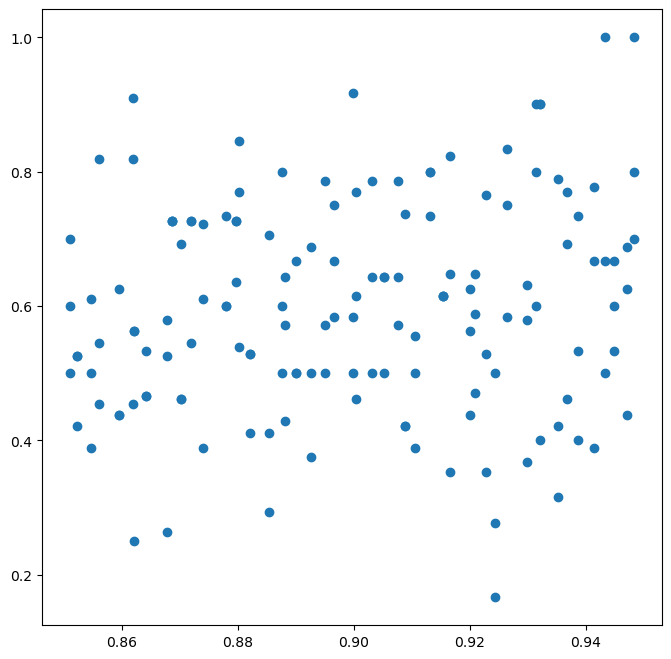

In [12]:
plt.scatter(experiment_df['edge_probability_core'], (experiment_df['true_positive'] / experiment_df['num_core_nodes']))

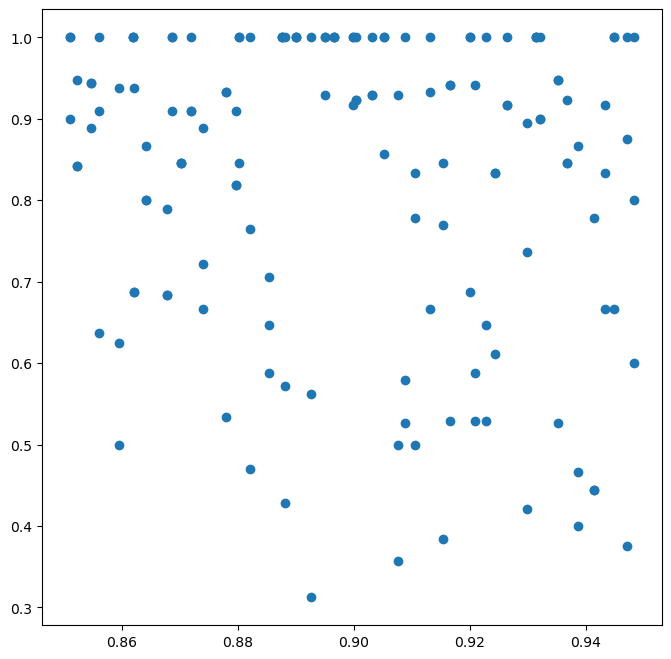

In [13]:
plt.scatter(experiment_df_percentage['edge_probability_core'], (experiment_df_percentage['true_positive'] / experiment_df_percentage['num_core_nodes']))

In [14]:
np.mean(experiment_df_percentage['num_core_nodes']) 

14.5

In [15]:
np.mean(experiment_df_percentage['num_core_nodes']+experiment_df_percentage['num_periphery_nodes']) 

89.0